In [1]:
import sys
sys.path.append('..')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm

In [13]:
import layers
import survaeflow
import survaeflow.transform.bijection as bij
from dataset.checkerboard import Checkerboard
from survaeflow.distribution import Uniform
from survaeflow.utils import pyplot_as_img

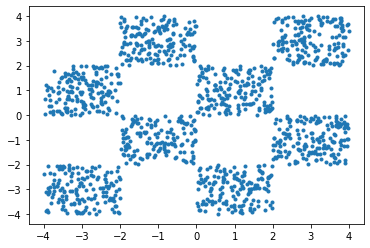

In [4]:
sample = Checkerboard.Sampler.sample(1280)
plt.plot(sample[:, 0], sample[:, 1], '.')

In [15]:
# model = layers.FlowBaseline(
#     tf.keras.Sequential([  # inputs: [B, 2]
#         tf.keras.layers.Dense(200, activation='relu'),
#         tf.keras.layers.Dense(100, activation='relu'),
#         tf.keras.layers.Dense(2)]))

model = survaeflow.Flow(
    prior=Uniform(),
    networks=[
        layers.ElemAbs(
            tf.keras.Sequential([  # inputs: [B, 2]
                tf.keras.layers.Dense(200, activation='relu'),
                tf.keras.layers.Dense(100, activation='relu'),
                tf.keras.layers.Dense(1)])),
        bij.Shift([0.0, 4.0]),
        bij.Scale([1/4, 1/8])])


In [16]:
optim = tf.keras.optimizers.Adam(1e-3)
writer = tf.summary.create_file_writer('./log/absflow')

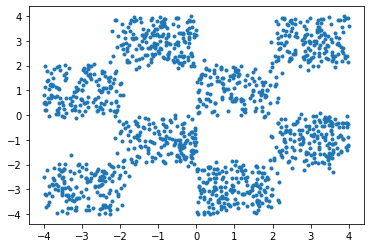

In [17]:
step, dataset = 0, Checkerboard(128000, 1280)
for _ in tqdm(range(10)):
    with tqdm(total=len(dataset), leave=False) as pbar:
        for x in dataset:
            with tf.GradientTape() as tape:
                _, log_prob = model(x)
                loss = -tf.reduce_mean(log_prob)
            grad = tape.gradient(loss, model.variables)
            optim.apply_gradients(zip(grad, model.variables))

            step += 1
            pbar.update()
            pbar.set_postfix({'loss': loss.numpy()})
            
            with writer.as_default():
                tf.summary.scalar('loss', loss, step=step)

    with writer.as_default():
        # [1280, 2]
        sample = Checkerboard.Sampler.sample(1280)
        plt.clf()
        plt.plot(sample[:, 0], sample[:, 1], '.')
        tf.summary.image('gt', pyplot_as_img()[None], step=step)

        resample = model.inverse(model.forward(sample))
        plt.clf()
        plt.plot(resample[:, 0], resample[:, 1], '.')
        tf.summary.image('rctor', pyplot_as_img()[None], step=step)

        prior = model.sample([1280, 2])
        plt.clf()
        plt.plot(prior[:, 0], prior[:, 1], '.')
        tf.summary.image('prior', pyplot_as_img()[None], step=step)
    